# Utility functions to measure the effect on arbitrary data

In [1]:
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)

In [27]:
import glob
import os

import numpy as np

import sep

from scipy.stats import sigmaclip
from scipy.signal import convolve2d
from matplotlib import pyplot as plt


def subtract_background(data):
    """Subtract the background from data.
    
    We assume that we are working with a bias or dark frame, so we don't
    have to worry about detecting and masking out objects.
    """
    background = sep.Background(data)
    
    sub_data = data - background.back()
    
    return sub_data


def build_cosmic_mask(data, num_sigma=5):
    """
    Build a cosmic ray mask for a residual image.

    This is a very naive algorithm. We are running on residuals, so we cut
    anything that is 5 sigma high or low. We then mask by a couple pixels
    around the cut too to capture the tail.
    """
    target_nmad = nmad(data)
    start_mask = np.abs(data - np.median(data)) > num_sigma * target_nmad

    num_edge_pixels = 2
    mask = ~(convolve2d(
        start_mask,
        np.ones((2*num_edge_pixels+1, 2*num_edge_pixels+1)),
        mode='same'
    ).astype(bool))

    return mask


def clipped_mean(data):
    clip_data, min_clip, max_clip = sigmaclip(data)
    
    mean = np.mean(clip_data)
    mean_err = np.std(clip_data) / np.sqrt(len(clip_data) - 1)

    return mean, mean_err


def nmad(data, *args, **kwargs):
    return 1.4826 * np.median(
        np.abs(np.asarray(data) - np.median(data, *args, **kwargs)),
        *args, **kwargs
    )

_cache_num_ones = {}
def cached_num_binary_ones(x):
    try:
        return _cache_num_ones[x]
    except KeyError:
        num_ones = _num_binary_ones(x)
        _cache_num_ones[x] = num_ones
        return num_ones

def _num_binary_ones(x):
    return bin(x).count('1')

def calc_num_binary_ones(x):
    x = np.atleast_1d(x)
    out = np.zeros(x.shape)
    for i in range(len(x.flat)):
        out.flat[i] = cached_num_binary_ones(x.flat[i])
    
    return out


def calculate_mean_residual(data, offset, do_diff=True, residuals=None, num_sigma=5,
                            debug=False, **kwargs):
    """Calculate the mean residuals as a function of the value of a
    reference pixel.
    
    This will return a list of raw pixel values and the average residuals
    for pixels separated by "offset" from pixels with those values.
    
    If do_diff is True, we look at a difference between the offset in the left
    direction and the right direction to cancel out effects like pickup.
    Otherwise, we only look in the direction specified by offset.
    
    The sign of offset doesn't really matter if used in diff mode since the
    positive and negative offsets will be subtracted from each other. However,
    if do_diff is False then they do matter. I have not determined the
    readout direction on each instrument tested here, so a positive offset may
    or may not be in the readout direction.
    """
    if residuals is None:
        # If we weren't given residuals, just assume that the image is relatively
        # flat and do a local background subtraction.
        residuals = subtract_background(data.astype(float).copy())
    
    # We look at the difference in residuals from one side to the next.
    ref_1 = np.roll(data, offset)
    ref_2 = np.roll(data, -offset)
    
    # Generate a mask to filter out cosmic rays/bad pixels.
    mask = build_cosmic_mask(data, num_sigma=num_sigma)
    # build_cosmic_mask returned a _positive_ mask where entries that should be used are set to True
    use_residuals = residuals[mask]
    use_ref_1 = ref_1[mask]
    use_ref_2 = ref_2[mask]

    # Figure out which range of pixel values to probe.
    min_values = np.percentile(data, 2)
    max_values = np.percentile(data, 98)
    pixel_values = np.arange(min_values, max_values+1)
    if debug:
        print("PIXEL VALUES: ", pixel_values[0], pixel_values[-1])
    
    residual_means_1 = []
    residual_means_2 = []
    residual_errs_1 = []
    residual_errs_2 = []
    
    for pixel_value in pixel_values:
        cut_1 = use_ref_1 == pixel_value
        cut_2 = use_ref_2 == pixel_value
        
        # For each value that is found in at least 20 pixels we calculate a
        # clipped mean of the residuals and estimate an error on it.
        if np.sum(cut_1) > 20:
            mean_1, mean_err_1 = clipped_mean(use_residuals[cut_1])
        else:
            mean_1 = -99
            mean_err_1 = -99

        
        if np.sum(cut_2) > 20:
            mean_2, mean_err_2 = clipped_mean(use_residuals[cut_2])
        else:
            mean_2 = -99
            mean_err_2 = -99
        
        residual_means_1.append(mean_1)
        residual_means_2.append(mean_2)
        residual_errs_1.append(mean_err_1)
        residual_errs_2.append(mean_err_2)
        
    residual_means_1 = np.array(residual_means_1)
    residual_means_2 = np.array(residual_means_2)
    residual_errs_1 = np.array(residual_errs_1)
    residual_errs_2 = np.array(residual_errs_2)

    # Calculate the difference in residuals in each direction. This is what
    # we will look at to see if the binary offset effect is present since it
    # is relatively clean.
    if do_diff:
        residual_means = residual_means_1 - residual_means_2
        residual_errs = np.sqrt(residual_errs_1**2 + residual_errs_2**2)
    else:
        residual_means = residual_means_1
        residual_errs = residual_errs_1
    if debug:
        print("RESIDUAL_MEANS: ", residual_means)
        print("RESIDUAL_ERRS: ", residual_errs)
    return pixel_values, residual_means, residual_errs

def setup_figure():
    #fig = plt.figure()
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2.5, 1], 'hspace': 0.})
    
    fig_parts = (fig, ax1, ax2)
    
    return fig_parts
    
    # fig.savefig(filename)

def plot_mean_residual(data, offset, label=None, do_diff=True,
                       residuals=None, fig_parts=None, **kwargs):
    """Plot the mean residuals calculated using calculate_mean_residual."""
    pixel_values, residual_means, residual_errs = \
        calculate_mean_residual(data, offset, do_diff=do_diff, residuals=residuals,
                                **kwargs)
    
    if fig_parts is not None:
        fig = fig_parts[0]
        ax = fig_parts[1]
    else:
        fig = plt.gcf()
        ax = fig.add_subplot(111)
        xlabel = 'Value of driver pixel (ADU)'
        ax.set_xlabel(xlabel)
        
        if offset == 1:
            offset_label = '1 pixel'
        else:
            offset_label = '%d pixels' % offset
        plt.ylabel('Mean residuals for an offset of %s (ADU)' % offset_label)
    
    ax.plot(pixel_values, residual_means, label=label)
    ax.fill_between(
        pixel_values,
        residual_means-residual_errs,
        residual_means+residual_errs,
        alpha=0.2
    )
    
    print('Median residual errors: %.4f' % np.median(residual_errs))
    
    # plt.ylabel('Mean residuals')
    
    return pixel_values

def finalize_figure(fig_parts, show_bits=4, min_bits=0, max_bits=11, legend_loc=0):
    fig, ax1, ax2 = fig_parts
    label_bit_changes(show_bits, ax1)
    labelled_locations = label_bit_changes(show_bits, ax2, legend=False)
    
    #ax1.set_ylim(-1.5, 1.5)
    #ax1.set_xlim(1250, 1360)
    #ax1.set_xlabel('Value of driver pixel (ADU)')
    ax1.set_ylabel('Residuals (ADU)')
    #ax1.set_title('')
    #ax1.tick_params('y', colors='C0')
    
    xmin, xmax = ax1.get_xlim()
    x = np.arange(int(np.floor(xmin)), int(np.ceil(xmax)))
    
    x_binary_count = calc_num_binary_ones(x)
    ax2.plot(x, x_binary_count, c='C0', label='Number of "1" bits in binary representation')
    #ax2.set_title('Number of ones in binary representation of driver pixel value')
    ax2.set_ylabel('Number of "1" bits')
    ax2.set_xlabel('Driver pixel value (ADU)')
    ax2.set_ylim(min_bits, max_bits)
    ax2.legend(loc=legend_loc)
    
    ax2.set_xticks(labelled_locations)
    
    ax1.legend()

    
def calc_num_bits(x):
    return bin(int(x)).count('1')
    
def label_bit_changes(min_bits=4, axis=None, legend=True):
    if axis is None:
        axis = plt.gca()

    x_lim = plt.gca().get_xlim()
    x_start = int(np.floor(x_lim[0]))
    x_end = int(np.ceil(x_lim[-1]))
    
    x_range = np.arange(x_start, x_end)
    
    first = True
    labelled_locations = []
    for x in x_range:
        num_diff_bits = calc_num_bits(x ^ (x+1))
        if num_diff_bits >= min_bits:
            if first and legend:
                label = 'Large binary transitions'
                first = False
            else:
                label = None
            axis.axvline(x+0.5, c='black', ls='--', alpha=0.2, label=label)
        
            labelled_locations.append(x + 0.5)
    
    return labelled_locations

# Allegheny Observatory Keeler SBIG

Processing /Volumes/PS1/STEPUP/2018-01-30/WDra-001B.fit
PIXEL VALUES:  2029.0 2075.0
Median residual errors: 0.0549
Processing /Volumes/PS1/STEPUP/2018-01-30/WDra-002B.fit
PIXEL VALUES:  2029.0 2075.0
Median residual errors: 0.0541
Processing /Volumes/PS1/STEPUP/2018-01-30/WDra-003B.fit
PIXEL VALUES:  2028.0 2074.0
Median residual errors: 0.0560
Processing /Volumes/PS1/STEPUP/2018-01-30/WDra-004B.fit
PIXEL VALUES:  2028.0 2073.0
Median residual errors: 0.0542
Processing /Volumes/PS1/STEPUP/2018-01-30/WDra-005B.fit
PIXEL VALUES:  2027.0 2073.0
Median residual errors: 0.0554
Processing /Volumes/PS1/STEPUP/2018-01-30/WDra-006B.fit
PIXEL VALUES:  2028.0 2073.0
Median residual errors: 0.0547
Processing /Volumes/PS1/STEPUP/2018-01-30/WDra-007B.fit
PIXEL VALUES:  2027.0 2072.0
Median residual errors: 0.0543
Processing /Volumes/PS1/STEPUP/2018-01-30/WDra-008B.fit
PIXEL VALUES:  2027.0 2072.0
Median residual errors: 0.0550
Processing /Volumes/PS1/STEPUP/2018-01-30/WDra-009B.fit
PIXEL VALUES:  2

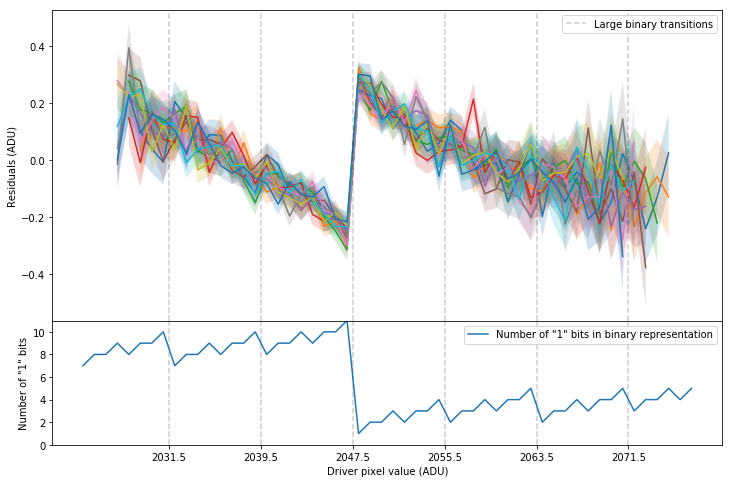

In [4]:
filenames = glob.glob('/Volumes/PS1/STEPUP/2018-01-30/*B.fit')
fig_parts = setup_figure()
# Seen for offset = 3 or 4
offset = 3
for filename in filenames:
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[0].data[:4096, :1024]
        plot_mean_residual(data, offset, fig_parts=fig_parts)

finalize_figure(fig_parts)

In [ ]:
filenames = glob.glob('/Volumes/PS1/STEPUP/2018-01-30/*B.fit')
fig_parts = setup_figure()
# Seen for offset = 3 or 4
offset = 4
for filename in filenames:
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[0].data[:4096, :1024]
        plot_mean_residual(data, offset, fig_parts=fig_parts)

finalize_figure(fig_parts)

In [ ]:
np.shape(data)

In [ ]:
print("Median: ", np.median(data))
print("Mean: ", np.mean(data))
print("Sigma: ", np.std(data))

# WIYN WHIRC

Processing /Volumes/PS1/SweetSpot/workspace/20141227/01.nonlincorr/dark_001.fits
PIXEL VALUES:  -10.999984741210938 55.00001525878906
RESIDUAL_MEANS:  [-0.06691511         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan -0.00550104         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan]
RESIDUAL_ERRS:  [0.07030699     

/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


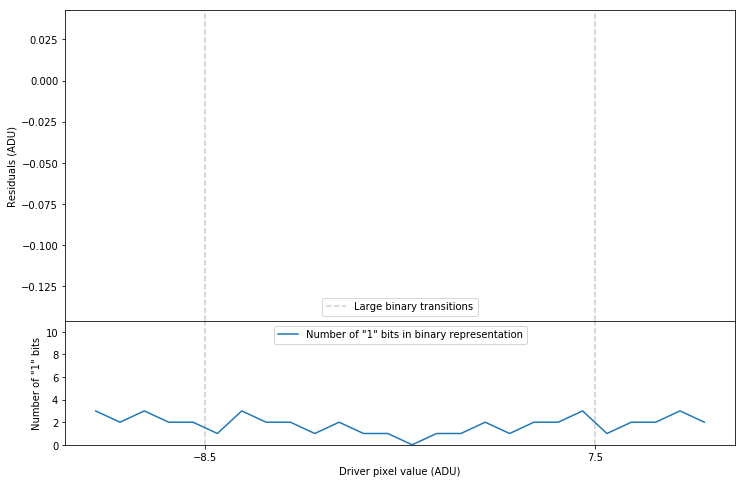

In [5]:
dirname = '/Volumes/PS1/SweetSpot/workspace/20141227/01.nonlincorr/'
darks = range(1, 11)
H_lamp_off_flats = range(12, 22)
H_lamp_on_flats = range(23, 33)
J_lamp_off_flats = range(34, 44)
J_lamp_on_flats = range(45, 55)

J_lamp_off_flats = [J_lamp_off_flats[0]]
J_lamp_on_flats = [J_lamp_on_flats[0]]

basename = ["flat_{:03d}.fits".format(s) for s in J_lamp_off_flats]

basename = ["dark_{:03d}.fits".format(s) for s in darks[0:1]]
filenames = [os.path.join(dirname, b) for b in basename]

fig_parts = setup_figure()
# Seen for offset = 3 or 4
offset = 4
for filename in filenames:
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[0].data[:2048, :2048]
        plot_mean_residual(data, offset, fig_parts=fig_parts, debug=True)

finalize_figure(fig_parts)

In [6]:
fits_file = fits.open(filename)
data = fits_file[0].data
np.shape(data)

(2048, 2048)

In [28]:
pixel_values, residual_means, residual_errs = calculate_mean_residual(data, offset=2, num_sigma=5)

In [29]:
print(residual_means)

[-0.19594733 -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.          0.03671402 -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.        ]


In [8]:
w, = np.where(np.isfinite(residual_means))
print(len(w))


2


In [9]:
print(pixel_values[w])

[-10.99998474  11.00001526]


In [10]:
hist, bin_edges = np.histogram(data, bins=np.arange(10111, 14327))

In [11]:
print("Median: ", np.median(data))
print("Mean: ", np.mean(data))
print("Sigma: ", np.std(data))

Median:  12.000019
Mean:  15.655648
Sigma:  63.93492


In [13]:
mask = build_cosmic_mask(data, num_sigma=5)

# SNIFS R

In [ ]:
filenames = glob.glob('./data/snifs_r/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[0].data[:4096, :1024]
        plot_mean_residual(data, 2, fig_parts=fig_parts)

finalize_figure(fig_parts, max_bits=10)

# SNIFS B

In [ ]:
filenames = glob.glob('./data/snifs_b/*.fits')
fig_parts = setup_figure()

for filename in filenames:
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[1].data[:4096, 3:1027]
        plot_mean_residual(data, 2, fig_parts=fig_parts)
        
finalize_figure(fig_parts)

# CFHT Megacam

In [ ]:
filename = './data/megacam/test_bias_1.fits.fz'
fig_parts = setup_figure()
#for index in range(1, 41):
for index in [1, 7, 21, 23]:
    with fits.open(filename) as fits_file:
        data = fits_file[index].data[:, :1056]
        
        # Filter for a subset of images in a region where the effect
        # is very prominent. I ran this originally and selected the
        # images with bias levels in this range to speed things up.
        if np.median(data) < 1270 or np.median(data) > 1290:
            continue
            
        print("Processing index %d" % index)

        plot_mean_residual(data, 1, fig_parts=fig_parts)

finalize_figure(fig_parts, legend_loc=1, max_bits=14)

# Note: we are plotting the data from multiple amplifiers here.
# The sign and amplitude of the binary offset effect changes from
# amplifier to amplifier.

# Keck DEIMOS

In [ ]:
filenames = glob.glob('./data/deimos/*.fits.gz')
fig_parts = setup_figure()
for filename in filenames:
    index = 4
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data
        targ_name = filename.split('/')[-1][:-8]
        plot_mean_residual(data, 2, label=targ_name, fig_parts=fig_parts)

# plt.xlim(1000, 1040)
finalize_figure(fig_parts, show_bits=4, legend_loc=3, min_bits=-5)

plt.savefig('./binary_offset_deimos.pdf')

# Keck HIRES

In [ ]:
filenames = glob.glob('./data/keck_hires/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 3
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data
        plot_mean_residual(data, 2, fig_parts=fig_parts)

finalize_figure(fig_parts, max_bits=9)

# Keck LRIS B

In [ ]:
filenames = glob.glob('./data/lris_b/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 3
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data[:2500, :]
        plot_mean_residual(data, 2, fig_parts=fig_parts)

finalize_figure(fig_parts, show_bits=4)

plt.xlim(1295, 1325);
fig_parts[1].set_ylim(-0.2, 0.2);

# Keck LRIS R

In [ ]:
filenames = glob.glob('./data/lris_r/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 1
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data
        plot_mean_residual(data, 2, fig_parts=fig_parts)

finalize_figure(fig_parts, show_bits=4, min_bits=3, max_bits=10)


# SDSS

In [ ]:
filenames = glob.glob('./data/sdss/idR-003459-i2-0008.fits')
fig_parts = setup_figure()
for filename in filenames:
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[0].data[:, 70:1060]
        plot_mean_residual(data, 1, fig_parts=fig_parts)

finalize_figure(fig_parts)

# No evidence of the binary offset effect here... notice the scale.

# HST WFC3 UVIS

In [ ]:
filenames = glob.glob('./data/hst_uvis/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 4
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data[:, 2110:]
        plot_mean_residual(data, 1, fig_parts=fig_parts)

finalize_figure(fig_parts, legend_loc=3, min_bits=-3)

# HST STIS

In [ ]:
filenames = glob.glob('./data/hst_stis_2/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 1
    #print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data
        plot_mean_residual(data, 1, fig_parts=fig_parts)

finalize_figure(fig_parts)

# Note: the amplitude varies quite a bit for the different STIS images.
# Here we show a range of different bias locations. The next image shows a zoom-in
# on the most extreme case.

In [ ]:
filenames = glob.glob('./data/hst_stis_2/*.fits')
fig_parts = setup_figure()
num_plotted = 0
for filename in filenames:
    index = 1
    #print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data
        if np.median(data) > 1360 or np.median(data) < 1300:
            continue

        print("Processing", filename)
        plot_mean_residual(data, 1, label=fits_file[0].header['ROOTNAME'], fig_parts=fig_parts)
        #print(fits_file[0].header['CCDGAIN'])
        
        num_plotted += 1        
        if num_plotted >= 3:
            break

plt.xlim(1310, 1375)
            
finalize_figure(fig_parts, max_bits=13)

# Zoom in on the most extreme STIS behavior observed.

plt.savefig('./binary_offset_stis.pdf')

In [ ]:
plt.savefig('./binary_offset_stis.pdf')

# HST ACS

In [ ]:
filenames = glob.glob('./data/hst_acs/*.fits')
fig_parts = setup_figure()
for filename in filenames[:3]:
    index = 1
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data[:, :2048]
        plot_mean_residual(data, 1, label=fits_file[0].header['ROOTNAME'], fig_parts=fig_parts)

finalize_figure(fig_parts, max_bits=9)

# ACS behaves very strangely. We find oscillating residuals that seem
# to only depend on the 0th bit. However, at the binary transition
# at 2463-2464 there is a large step in the residuals.

plt.savefig('./binary_offset_hst_acs.pdf')

# VLT FORS 1

In [ ]:
filenames = glob.glob('./data/vlt_fors_1/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 0
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data.T
        plot_mean_residual(data, 1, fig_parts=fig_parts)

finalize_figure(fig_parts, max_bits=8, show_bits=4)

# VLT FORS 2

In [ ]:
filenames = glob.glob('./data/vlt_fors_2/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 0
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data.T
        plot_mean_residual(data, 1, label=fits_file[0].header['DATE'], fig_parts=fig_parts)

finalize_figure(fig_parts, max_bits=9)

# VLT MUSE

In [ ]:
filenames = glob.glob('./data/vlt_muse/*.fits.fz')
fig_parts = setup_figure()
for filename in filenames:
    index = 3
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data[:2100, :2100]
        plot_mean_residual(data, 1, fig_parts=fig_parts)

finalize_figure(fig_parts, min_bits=3, max_bits=10)

# No evidence of the binary offset effect, residuals are smooth. The slope
# here is probably due to some other form of directed correlations between
# pixels.

# Kepler

In [ ]:
filenames = glob.glob('./data/kepler/*.fits')
fig_parts = setup_figure()
for filename in filenames:
#filename = filenames[0]
#for index in range(1, 81):
    index = 53
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data[:, 1110:]
        #print(index, nmad(data))
        plot_mean_residual(data, 3, fig_parts=fig_parts)

finalize_figure(fig_parts, min_bits=5, max_bits=17)

# I was unable to find a bias or flat image for Kepler. Instead, I'm
# just looking at the overscan region on the edge of some of the FFI
# images. Unfortunately this region is too small and noisy to really
# say anything meaningful.

# Gemini GMOS-S Hamamatsu (post 2014)

In [ ]:
filenames = glob.glob('./data/gemini_gmos_s_hamamatsu/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 3
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data
        plot_mean_residual(data, 2, fig_parts=fig_parts)

finalize_figure(fig_parts)

# No effect seen

# Gemini GMOS-S E2V (pre 2014)

In [ ]:
filenames = glob.glob('./data/gemini_gmos_s_e2v/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 2
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data
        plot_mean_residual(data, 2, fig_parts=fig_parts)

finalize_figure(fig_parts)

# Gemini GMOS-N Hamamatsu (post 2017)

In [ ]:
filenames = glob.glob('./data/gemini_gmos_n_hamamatsu/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 6
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data[120:, 20:]
        plot_mean_residual(data, 1, fig_parts=fig_parts)

finalize_figure(fig_parts, max_bits=13)

# No effect seen

# Gemini GMOS-N E2V (pre 2017)

In [ ]:
filenames = glob.glob('./data/gemini_gmos_n_e2v/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 2
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data
        plot_mean_residual(data, 2, fig_parts=fig_parts)

finalize_figure(fig_parts)

# Blanco DECam

In [ ]:
filenames = glob.glob('./data/blanco_decam/dec009765.fits.fz')
fig_parts = setup_figure()
for filename in filenames:
    index = 2
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data[:, 1024:]
        plot_mean_residual(data, 2, fig_parts=fig_parts)

finalize_figure(fig_parts)

fig_parts[1].set_ylim(-0.5, 0.5)

# No effect seen

# Subaru Hyper Suprime-Cam

In [ ]:
filenames = sorted(glob.glob('./data/subaru_hsc/*.fits'))
fig_parts = setup_figure()
for filename in filenames:
    index = 0
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        for chip_section in range(4):
            # print("Chip %d" % chip_section)
            data = fits_file[index].data[:, chip_section*536+20:(chip_section+1)*536-20]
            
            # Cut to a representative sample for display purposes.
            if np.median(data) > 1455 or np.median(data) < 1420:
                continue
                
            plot_mean_residual(data, 1, label=fits_file[0].header['FRAMEID'], fig_parts=fig_parts)

finalize_figure(fig_parts, show_bits=4, max_bits=9)

plt.xlim(1420, 1455)

# The residuals are definitely correlated with the LSB here. There doesn't seem
# to be a trend with the higher bits though. I zoomed in on a selection of images.
# Zoom out to see more.

plt.savefig('./binary_offset_subaru_hsc.pdf')

In [ ]:
plt.savefig('./binary_offset_subaru_hsc.pdf')

# Subaru Suprime-Cam

In [ ]:
filenames = glob.glob('./data/subaru_sc/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 0
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        for chip_section in range(4):
            data = fits_file[index].data[:, chip_section*568:(chip_section+1)*568]
            plot_mean_residual(data, 1, fig_parts=fig_parts)

finalize_figure(fig_parts)

# There is some interesting structure in the residuals, but it is smoothly
# varying. This is not the binary offset effect.

# Subaru Focas

In [ ]:
filenames = glob.glob('./data/subaru_focas/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 0
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        chip_section = 0
        #for chip_section in range(4):
        data = fits_file[index].data[:, chip_section*276:(chip_section+1)*276]
        plot_mean_residual(data, 2, fig_parts=fig_parts)

finalize_figure(fig_parts)

# Evidence of an effect based on the LSB. However, it is not always
# present.

# WHT OASIS

In [ ]:
filenames = glob.glob('./data/wht_oasis/*.fits')
file_06 = fits.open('./data/wht_oasis/471086t.fits')
file_120 = fits.open('./data/wht_oasis/471197t.fits')
file_300 = fits.open('./data/wht_oasis/471230t.fits')

data_06 = file_06[0].data
data_120 = file_120[0].data
data_300 = file_300[0].data

sub_06 = data_06 - np.median(data_06[:, -40:])
sub_120 = data_120 - np.median(data_120[:, -40:])
sub_300 = data_300 - np.median(data_300[:, -40:])

# These aren't very clean...


residuals_06 = sub_06 - sub_300 * 0.6 / 300
residuals_120 = sub_120 - sub_300 * 120 / 300

fig_parts = setup_figure()
plot_mean_residual(data_06, 1, residuals=residuals_06, fig_parts=fig_parts)
plot_mean_residual(data_120, 1, residuals=residuals_120, fig_parts=fig_parts)

finalize_figure(fig_parts)

# Nothing obvious going on.

# Subaru HSC advanced tests

In [ ]:
filename = './data/subaru_hsc/HSCA00138013.fits'

with fits.open(filename) as fits_file:
    data = fits_file[0].data[:, 20:516]

sub_data = subtract_background(data.astype(float).copy())

In [ ]:
# Is there is a real difference for HSC between two adjacent pixel values?
# 1425 and 1427 have the same distribution of residuals, but 1426 is very
# different.
plt.figure();

plt.hist(sub_data[np.roll(data, 1) == 1425], 20, range=(-10, 10), edgecolor='C0', fill=False, label='T-1 = 1425', histtype='step', normed=True);
plt.hist(sub_data[np.roll(data, 1) == 1426], 20, range=(-10, 10), edgecolor='C1', fill=False, label='T-1 = 1426', histtype='step', normed=True);
plt.hist(sub_data[np.roll(data, 1) == 1427], 20, range=(-10, 10), edgecolor='C2', fill=False, label='T-1 = 1427', histtype='step', normed=True);

plt.xlabel('Residuals of target pixel on CCD')
plt.ylabel('Fraction of occurences')
plt.legend()

In [ ]:
# Do specific values appear more often on a specific row or column?
# No evidence that this is the case.
plt.figure()
for i in [1425, 1426, 1427]:
    plt.plot(np.sum((np.roll(data, 1) == i), axis=1), label='T-1 = %d' % i)
    
plt.legend()